In [1]:
import cosmology
import scipy.special as spfun
import galsim
import astropy.io.fits as pyfits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# NFW Lensing Simulator
A module to create NFW lens Surface Density ($\Sigma$),

density contrast ($\delta$),

and lensing kappa ($\kappa$).

Based on the integral functions of a spherical NFW profile: 

Wright & Brainerd(2000, ApJ, 534, 34)

## Evolution of average density
$$\rho_M(z)=\frac{\rho_c(0)\Omega_M(0)}{a^3}$$

$$H(z)=H_0 E(z)$$

$$\rho_c(z)=\rho_c(0)*E(z)^2$$

$$\Omega_M(z)=\frac{\Omega_M(0)}{E(z)^{2} a^3}$$

## Surface density to Kappa
$$\kappa=\frac{\Sigma}{\Sigma_{cr}}$$
$\Sigma$ is termed surface density, which is the intergration of the forground density distribution along the line-of-sight.
Given that the forground matter is located at distance $[D_l,D_l+dD_l]$, the surface density is 
$$d\Sigma(\vec{\theta}) = \rho(D_l)\delta(\vec{\theta} D_l,D_l) dD_l$$
$$d\Sigma(\vec{\theta}) = \frac{\rho_0 \Omega_M}{a^3(D_l)} \delta(\vec{\theta} D_l,D_l) dD_l$$

$\Sigma_{cr}$ is the critical surface density where
$$\frac{1}{\Sigma_{cr}}(D_l,D_s)=\frac{4 \pi G}{c^2}\frac{D_{ls} D_{l}}{D_{s}}$$
$$\frac{1}{\Sigma_{cr}}(D_l,D_s)=\frac{3H_0^2}{2c^2 \rho_0}\frac{D_{ls} D_{l}}{D_{s}}$$

## Density Contrast to Kappa
The kappa caused by the such foreground mass distribution to the source at redshift $z_s(D_s)$ is
$$d\kappa(\vec{\theta},\chi_s)= \frac{3H_0^2\Omega_M}{2 c^2} \frac{\chi_l \chi_{sl}}{\chi_s} \frac{\delta(\chi_l \vec{\theta},\chi_l)}{a(\chi_l)} d\chi_l $$

Intergration of the contributions of foreground matter along the ling-of-sight and we can get Equation (1) in Leonard et al. (2013, GLIMPSE)

$$\kappa(\vec{\theta},\chi_s)=\frac{3H_0^2\Omega_M}{2 c^2} \int_0^{\chi_s} d\chi_l \frac{\chi_l \chi_{sl}}{\chi_s} \frac{\delta(\chi_l \vec{\theta},\chi_l)}{a(\chi_l)} $$

Express with redshift (z)
$$\kappa(\vec{\theta},z_s)=\frac{3H_0\Omega_M}{2 c} \int_0^{z_s} dz_l \frac{\chi_l \chi_{sl}}{\chi_s} \frac{\delta(\vec{\theta},z_l) (1+z_l)}{E(z_l)} $$
If with redshift uncerntainty
$$\kappa(\vec{\theta},z)=\frac{3H_0\Omega_M}{2 c} \int dz_s P(z_s|z,\vec{\theta}) \int_0^{z_s} dz_l \frac{\chi_l \chi_{sl}}{\chi_s} \frac{\delta(\vec{\theta},z_l) (1+z_l)}{E(z_l)} $$

## Geometric Equations
$$dt = \frac{da}{a H(a)}$$
$$d\chi = \frac{c}{a} dt$$
$$d \chi   = \frac{c da}{a^2 H(a)} $$
$$d z   = -\frac{ da}{a^2} $$
$$d \chi   = -\frac{c dz}{H(a)} $$
$$ \chi_l = \chi_0 - \chi$$
$$d \chi_l   = \frac{c dz}{H(z)} $$

## Density Contrast to Kappa
$$\kappa(\vec{\theta},z_s)=\frac{3H_0\Omega_M}{2 c} \int_0^{z_s} dz_l \frac{\chi_l \chi_{sl}}{\chi_s} \frac{\delta(\vec{\theta},z_l) (1+z_l)}{E(z_l)} $$
## Pixelization along line-of-sight
$$\kappa(\vec{\theta},z_s)=\frac{3H_0\Omega_M}{2 c} \sum_i  \int_{z_i-\Delta z/2}^{z_i+\Delta z/2} dz_l \frac{\chi_l \chi_{sl}}{\chi_s} \frac{\delta(\vec{\theta},z_l) (1+z_l)}{E(z_l)} $$
$$\kappa(\vec{\theta},z_s)=\frac{3H_0\Omega_M}{2 c} \sum_i \delta(\vec{\theta},z_i) \frac{\chi_l \chi_{sl}}{\chi_s} \frac{ (1+z_i)}{E(z_i)} \Delta z $$

In [2]:
#important constant
C_LIGHT=2.99792458e8        # m/s
GNEWTON=6.67428e-11         # m^3/kg/s^2
KG_PER_SUN=1.98892e30       # kg/M_solar
M_PER_PARSEC=3.08568025e16  # m/pc
def four_pi_G_over_c_squared():
    # = 1.5*H0^2/roh_0/c^2
    # We want it return 4piG/c^2 in unit of Mpc/M_solar 
    # in unit of m/kg
    fourpiGoverc2 = 4.0*np.pi*GNEWTON/(C_LIGHT**2)
    # in unit of pc/M_solar 
    fourpiGoverc2 *= KG_PER_SUN/M_PER_PARSEC
    # in unit of Mpc/M_solar
    fourpiGoverc2 /= 1.e6
    return fourpiGoverc2   


class nfw_lensTJ03():
    """
    Based on the integral functions of a spherical NFW profile: 
    Wright & Brainerd(2000, ApJ, 534, 34)
    
    @param mass         Mass defined using a spherical overdensity of 200 times the critical density
                        of the universe, in units of M_solar/h.
    @param conc         Concentration parameter, i.e., ratio of virial radius to NFW scale radius.
    @param redshift     Redshift of the halo.
    @param ra           ra of halo center  [arcsec].
    @param dec          dec of halo center [arcsec].
    @param omega_m      Omega_matter to pass to Cosmology constructor. [default: 0.3]
                        omega_lam is set to 1-omega_matter.
    """
    def __init__(self,mass,conc,redshift,ra,dec,omega_m=0.3):
        self.cosmo=cosmology.Cosmo(h=1,omega_m=omega_m)
        self.M = float(mass)
        self.c = float(conc)
        # \delta_c in equation (2)
        self.A=1./(np.log(1+self.c)-(self.c)/(1+self.c))
        self.delta_nfw  =200./3*self.c**3*self.A
        self.z = float(redshift)
        # E(z)^{-1}
        self.ezInv=self.cosmo.Ez_inverse(self.z)
        # critical density 
        # in unit of M_solar / Mpc^3
        rho_cZ   = self.cosmo.rho0()/self.ezInv**2
        # charateristic matter density within R200 at redshift z
        # \delta_c \times \rho_c in equation (1),(11)
        self.rho_s=   rho_cZ*self.delta_nfw
        # scale radius
        self.a = 1./(1.+self.z)
        self.DaLens=self.cosmo.Da(0.,self.z)
        # ra_l,dec_l
        self.ra=ra
        self.dec=dec
        
        # First we get the virial radius, which is defined for some spherical overdensity as
        # 3 M / [4 pi (r_vir)^3] = overdensity
        # Here we have overdensity = 200 * rhocrit, to determine R200 (angular distance). 
        # The factor of 1.63e-5 comes from the following set of prefactors: 
        # (3 / (4 pi * 200 * rhocrit))^(1/3), where rhocrit = 2.8e11 h^2 M_solar / Mpc^3. 
        # (H0=100,DH=C_LIGHT/1e3/H0,rho_crit0=1.5/four_pi_G_over_c_squared()/(DH)**2.)
        # The mass in the equation below is in M_solar/h, 
        # which is how the final units are Mpc/h.
        R200 = 1.63e-5*(self.M*self.ezInv**2)**(1./3.) # in Mpc/h
        self.rs = R200/self.c

        # convert scale radius in arcsec
        dl = self.cosmo.Da(0.,self.z) # in Mpc/h
        scale = self.rs / dl
        arcsec2rad = np.pi/180./3600
        self.rs_arcsec = scale/arcsec2rad
        return
    
    
    def __DdRs(self,ra_s,dec_s):
        """Calculate 'x' the radius r in units of the NFW scale
        radius, r_s.
        @param ra_s       ra of sources [arcsec].
        @param dec_s      dec of sources [arcsec].
        """
        x = ((ra_s - self.ra)**2 + (dec_s - self.dec)**2)**0.5/self.rs_arcsec
        return x
    
    def __sin2phi(self,ra_s,dec_s):
        """Calculate cos2phi and sin2phi with reference to the halo center
        @param ra_s       ra of sources [arcsec].
        @param dec_s      dec of sources [arcsec].
        """
        
        # pure tangential shear, no cross component
        dx = ra_s - self.ra
        dy = dec_s - self.dec
        drsq = dx*dx+dy*dy
        return np.divide(2*dx*dy, drsq, where=(drsq != 0.))
    
    
    def __cos2phi(self,ra_s,dec_s):
        """Calculate cos2phi and sin2phi with reference to the halo center
        @param ra_s       ra of sources [arcsec].
        @param dec_s      dec of sources [arcsec].
        """
        
        # pure tangential shear, no cross component
        dx = ra_s - self.ra
        dy = dec_s - self.dec
        drsq = dx*dx+dy*dy
        
        return np.divide(dx*dx-dy*dy, drsq, where=(drsq != 0.))
    
    
    def __Sigma(self,x0):
        c   = np.float(self.c)
        out = np.zeros_like(x0, dtype=float)

        # 3 cases: x < 1-0.001, x > 1+0.001, and |x-1| < 0.001
        mask = np.where(x0 < 0.999)[0]
        x=x0[mask]
        out[mask] = -np.sqrt(c**2.-x**2.)/(1-x**2.)/(1+c)+1./(1-x**2.)**1.5*np.arccosh((x**2.+c)/x/(1.+c))
        

        mask = np.where((x0 > 1.001) & (x0<c))[0]
        x=x0[mask]
        out[mask] = -np.sqrt(c**2.-x**2.)/(1-x**2.)/(1+c)-1./(x**2.-1)**1.5*np.arccos((x**2.+c)/x/(1.+c))

       
        mask = np.where((x0 >= 0.999) & (x0 <= 1.001))[0]
        x=x0[mask]
        out[mask] = (-2.+c+c**2.)/(3.*np.sqrt(-1.+c)*(1+c)**(3./2))+((2.-c-4.*c**2.-2.*c**3.)*(x-1.))/(5.*np.sqrt(-1.+c)*(1+c)**(5/2.))
        
        mask = np.where(x0 >= c)[0]
        out[mask]=0.
        return out* self.rs * self.rho_s*2.
    
    
    
    def Sigma(self,ra_s,dec_s):
        """Calculate Surface Density (Sigma) of halo.
        Equation (11) in Wright & Brainerd (2000, ApJ, 534, 34).
        @param ra_s       ra of sources [arcsec].
        @param dec_s      dec of sources [arcsec].
        """
        
        # convenience: call with single number
        assert isinstance(ra_s,np.ndarray)==isinstance(dec_s,np.ndarray),\
            'ra_s and dec_s do not have same type'
        if not isinstance(ra_s,np.ndarray):
            ra_sA=np.array([ra_s], dtype='float')
            dec_sA=np.array([dec_s], dtype='float')
            return self.Sigma(ra_sA,dec_sA)[0]
        assert len(ra_s)==len(dec_s),\
            'input ra and dec have different length '
        x=self.__DdRs(ra_s,dec_s)
        return self.__Sigma(x)
        
    def __DeltaSigma(self,x0):
        c   = np.float(self.c)
        out = np.zeros_like(x0, dtype=float)

        # 4 cases:
        # x < 1-0.001,|x-1| <= 0.001
        # 1.001<x<=c, x>c

        mask = np.where(x0 < 0.0001)[0]
        out[mask]=1./2.
        
        mask = np.where((x0 < 0.999) & (x0>0.0001) )[0]
        x=x0[mask]
        out[mask] = (-2.*c+((2.-x**2.)*np.sqrt(c**2.-x**2.))/(1-x**2))/((1+c)*x**2.)+((2-3*x**2)*np.arccosh((c+x**2)/((1.+c)*x)))/(x**2*(1-x**2.)**1.5)\
            +(2*np.log(((1.+c)*x)/(c+np.sqrt(c**2-x**2))))/x**2
        
        mask = np.where((x0 > 1.001) & (x0< c))[0]  
        x=x0[mask]
        out[mask] = (-2.*c+((2.-x**2.)*np.sqrt(c**2.-x**2.))/(1-x**2))/((1+c)*x**2.)-((2-3*x**2)*np.arccos((c+x**2)/((1.+c)*x)))/(x**2*(-1+x**2.)**1.5)\
            +(2*np.log(((1.+c)*x)/(c+np.sqrt(c**2-x**2))))/x**2

        
        mask = np.where((x0 >= 0.999) & (x0 <= 1.001))[0]
        x=x0[mask]
        out[mask] = (10*np.sqrt(-1.+c**2)+c*(-6-6*c+11*np.sqrt(-1.+c**2))+6*(1 + c)**2*np.log((1. + c)/(c +np.sqrt(-1.+c**2))))/(3.*(1+c)**2)-\
            (-1.+x)*((94 + c*(113 + 60*np.sqrt((-1.+c)/(1 + c))+4*c*(-22 + 30*np.sqrt((-1 + c)/(1 + c)) + c*(-26 + 15*np.sqrt((-1 + c)/(1 + c))))))/(15.*(1.+c)**2*np.sqrt(-1.+c**2))- 4*np.log(1.+c)+\
            4*np.log(c +np.sqrt(-1.+c**2)))
        
        mask = np.where(x0 >= c)[0]
        x=x0[mask]
        out[mask] = 2./self.A/x**2.
        return out*self.rs * self.rho_s*2.
    
    def DeltaSigma(self,ra_s,dec_s):
        """Calculate excess surface density of halo.
        @param ra_s       ra of sources [arcsec].
        @param dec_s      dec of sources [arcsec].
        """
        
        # convenience: call with single number
        assert isinstance(ra_s,np.ndarray)==isinstance(dec_s,np.ndarray),\
            'ra_s and dec_s do not have same type'
        if not isinstance(ra_s,np.ndarray):
            ra_sA=np.array([ra_s], dtype='float')
            dec_sA=np.array([dec_s], dtype='float')
            return self.DeltaSigma(ra_sA,dec_sA)[0]
        assert len(ra_s)==len(dec_s),\
            'input ra and dec have different length '
        x=self.__DdRs(ra_s,dec_s)
        return self.__DeltaSigma(x)
    
    
    def DeltaSigmaComplex(self,ra_s,dec_s):
        """Calculate excess surface density of halo.
        return a complex array \Delta \Sigma_1+ i \Delta \Sigma_2
        @param ra_s       ra of sources [arcsec].
        @param dec_s      dec of sources [arcsec].
        """
        # convenience: call with single number
        assert isinstance(ra_s,np.ndarray)==isinstance(dec_s,np.ndarray),\
            'ra_s and dec_s do not have same type'
        if not isinstance(ra_s,np.ndarray):
            ra_sA=np.array([ra_s], dtype='float')
            dec_sA=np.array([dec_s], dtype='float')
            return self.DeltaSigmaComplex(ra_sA,dec_sA)[0]
        assert len(ra_s)==len(dec_s),\
            'input ra and dec have different length '
        x=self.__DdRs(ra_s,dec_s)
        DeltaSigma=self.__DeltaSigma(x)
        DeltaSigma1 = -DeltaSigma*self.__cos2phi(ra_s,dec_s)
        DeltaSigma2 = -DeltaSigma*self.__sin2phi(ra_s,dec_s)
        return DeltaSigma1+1j*DeltaSigma2
        
        
        
    def lensKernel(self,z_s):
        """Lensing kernel of halo as function of source redshift.
        @param z_s        redshift of sources.
        """
        
        # convenience: call with single number
        if not isinstance(z_s, np.ndarray):
            return self.lensKernel(np.array([z_s], dtype='float'))[0]
        # lensing weights: the only thing that depends on z_s
        # First mask the data with z<z_l
        k_s =   np.zeros(len(z_s))
        mask=   z_s>self.z
        k_s[mask] =   self.cosmo.Da(self.z,z_s[mask])*self.DaLens/self.cosmo.Da(0.,z_s[mask])*four_pi_G_over_c_squared()
        return k_s
    
    
    def Sigma_M_bin(self,z_bin_min,z_bin_max):
        """Zero-order Surface mass density
        within redshift bin [z_bin_min,z_bin_max].
        @param z_bin_min   minimum of redshift bin.
        @param z_bin_max   maximum of redshift bin.
        """
        
        # convenience: call with single number
        assert isinstance(z_bin_min,np.ndarray)==isinstance(z_bin_max,np.ndarray),\
            'z_bin_min and z_bin_max do not have same type'
        
        if not isinstance(z_bin_min,np.ndarray):
            z_bin_minA=np.array([z_bin_min], dtype='float')
            z_bin_maxA=np.array([z_bin_max], dtype='float')
            return self.Sigma(z_bin_minA,z_bin_maxA)[0]
        assert len(z_bin_min)==len(z_bin_max),\
            'input ra and dec have different length '
        # Here we approximate the average rho_M for redshif bin
        # as the rho_M at the mean redshift
        rhoM_ave=self.cosmo.rho_m((z_bin_min+z_bin_max)/2.)
        DaBin=self.cosmo.Da(z_bin_min,z_bin_max)
        return rhoM_ave*DaBin

    
    
def ksInverse(gMap):
    gFouMap =   np.fft.fft2(gMap)
    e2phiF  =   e2phiFou(gFouMap.shape)
    kFouMap =   gFouMap/e2phiF*np.pi
    kMap    =   np.fft.ifft2(kFouMap)
    return kMap

def ksForward(kMap):
    kFouMap =   np.fft.fft2(kMap)
    e2phiF  =   e2phiFou(gFouMap.shape)
    gFouMap =   kFouMap*e2phiF/np.pi
    gMap    =   np.fft.ifft2(gFouMap)
    return gMap

def e2phiFou(shape):
    ny1,nx1 =   shape
    e2phiF  =   np.zeros(shape,dtype=complex)
    for j in range(ny1):
        jy  =   (j+ny1//2)%ny1-ny1//2
        jy  =   jy/ny1
        for i in range(nx1):
            ix  =   (i+nx1//2)%nx1-nx1//2
            ix  =   ix/nx1
            if (i**2+j**2)>0:
                e2phiF[j,i]    =   np.complex((ix**2.-jy**2.),2.*ix*jy)/(ix**2.+jy**2.)
            else:
                e2phiF[j,i]    =   1.
    return e2phiF*np.pi

# NFW Halolet $\Delta \Sigma$

1006425657833233.9


Text(0, 0.5, '$\\Delta \\Sigma_r$')

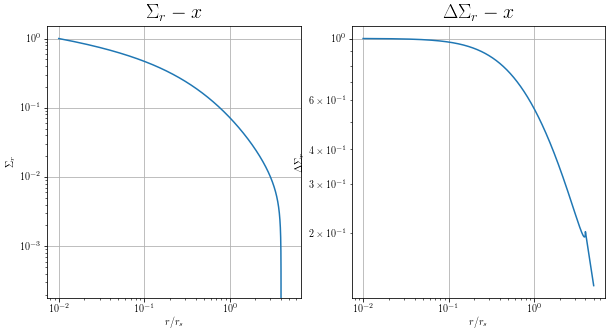

In [8]:
halo=nfw_lensTJ03(mass=1e15,conc=4.,redshift=0.3,ra=0.,dec=0.)
x=np.linspace(0.01,5.,3000)
y=np.zeros(3000)
DeltaSigma=halo.DeltaSigma(x*halo.rs_arcsec,y*halo.rs_arcsec)
Sigma=halo.Sigma(x*halo.rs_arcsec,y*halo.rs_arcsec)
print(2*np.pi*np.sum(Sigma*x)*halo.rs**2.*(x[1]-x[0]))
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,2,1)
ax.loglog(x,Sigma/Sigma[0])
ax.grid()
ax.set_title(r'$ \Sigma_r - x$',fontsize=20)
ax.set_xlabel(r'$r/r_s$')
ax.set_ylabel(r'$ \Sigma_r$')

ax=fig.add_subplot(1,2,2)
ax.loglog(x,DeltaSigma/DeltaSigma[0])
ax.grid()
ax.set_title(r'$\Delta \Sigma_r - x$',fontsize=20)
ax.set_xlabel(r'$r/r_s$')
ax.set_ylabel(r'$\Delta \Sigma_r$')

# Halolet Atom

In [80]:
def haloCS02Atom(r_s,ngrid,c=9.,fou=True):
    """Make haloTJ03 atom.
    https://arxiv.org/pdf/astro-ph/0206508.pdf
    Eq.(81) Eq.(82)
    @param r_s        scale radius [unit of pixel].
    @param ngrid      number of pixel in x and y directions.
    @param c          truncation ratio (concentration)
    @param fou        in Fourier space
    """
    A= 1./(np.log(1+c)-c/(1.+c))
    x,y=np.meshgrid(np.fft.fftfreq(ngrid),np.fft.fftfreq(ngrid))
    x*=(2*np.pi);y*=(2*np.pi)
    r=np.sqrt(x**2+y**2)*r_s
    mask=r>0.01
    atomFou=np.zeros_like(r, dtype=float)
    r1=r[mask]
    si1,ci1=spfun.sici((1+c)*r1)
    si2,ci2=spfun.sici(r1)
    atomFou[mask]=A*(sin(r1)*(si1-si2)-np.sin(c*r1)/(1+c)/r1+np.cos(r1)*(ci1-ci2))
    r0=r[~mask]
    atomFou[~mask]=1.+A*(c+c**3/(6*(1 + c)) + 1/4.*(-2.*c-c**2.-2*np.log(1+c)))*r0**2.
    if fou:
        return atomFou
    else:
        return real(np.fft.ifft2(atomFou))
np.fft.fftshift(haloCS02Atom(4,32,fou=False))
np.fft.fftshift(haloCS02Atom(4,32))

array([[0.00223863, 0.00236866, 0.00248348, ..., 0.00265155, 0.00248348,
        0.00236866],
       [0.00236866, 0.00249975, 0.00266228, ..., 0.00288018, 0.00266228,
        0.00249975],
       [0.00248348, 0.00266228, 0.00288461, ..., 0.00312027, 0.00288461,
        0.00266228],
       ...,
       [0.00265155, 0.00288018, 0.00312027, ..., 0.0033436 , 0.00312027,
        0.00288018],
       [0.00248348, 0.00266228, 0.00288461, ..., 0.00312027, 0.00288461,
        0.00266228],
       [0.00236866, 0.00249975, 0.00266228, ..., 0.00288018, 0.00266228,
        0.00249975]])